In [ ]:
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
import os
from tqdm import tqdm
import sys, random
from pathlib import Path
import copy
import time

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
data_transforms = {
    'female': transforms.Compose([transforms.Resize([64,64]),  
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
    
    # 'male': transforms.Compose([transforms.Resize([64,64]),  
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [ ]:
data_dir = '/content/drive/MyDrive/smarcle_face_dataset/NEW_TRAIN' 

image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['female']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['female']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['female']}

class_names = image_datasets['female'].classes
class_names

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['active', 'clean', 'cute', 'elegant', 'natural', 'sexy']

In [ ]:
resnet = models.resnet50(pretrained=True)  
num_ftrs = resnet.fc.in_features   
resnet.fc = nn.Linear(num_ftrs, 33) 
resnet = resnet.to(DEVICE)
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
 
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
ct = 0 
for child in resnet.children():  
    ct += 1  
    if ct < 6: 
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['female']: 
            if phase == 'female': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'female'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
    
                    if phase == 'female':   
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            if phase == 'female':  
                scheduler.step()
 
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 

 
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

 
    model.load_state_dict(best_model_wts) 

    return model

In [ ]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30) 

torch.save(model_resnet50, 'resnet50.pt')

-------------- epoch 1 ----------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


female Loss: 1.8556 Acc: 0.2905
Completed in 2m 56s
-------------- epoch 2 ----------------
female Loss: 1.5185 Acc: 0.4223
Completed in 0m 39s
-------------- epoch 3 ----------------
female Loss: 1.3632 Acc: 0.4830
Completed in 0m 39s
-------------- epoch 4 ----------------
female Loss: 1.1735 Acc: 0.5684
Completed in 0m 39s
-------------- epoch 5 ----------------
female Loss: 1.0059 Acc: 0.6234
Completed in 0m 39s
-------------- epoch 6 ----------------
female Loss: 0.8508 Acc: 0.6913
Completed in 0m 39s
-------------- epoch 7 ----------------
female Loss: 0.6623 Acc: 0.7646
Completed in 0m 39s
-------------- epoch 8 ----------------
female Loss: 0.3738 Acc: 0.8794
Completed in 0m 39s
-------------- epoch 9 ----------------
female Loss: 0.2208 Acc: 0.9409
Completed in 0m 39s
-------------- epoch 10 ----------------
female Loss: 0.1551 Acc: 0.9620
Completed in 0m 39s
-------------- epoch 11 ----------------
female Loss: 0.1189 Acc: 0.9701
Completed in 0m 39s
-------------- epoch 12 --

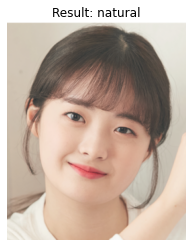

In [ ]:
# Paths for image directory and model
#IMDIR=sys.argv[1])
MODEL='resnet50.pt'

# Load the model for testing
model = torch.load(MODEL)
model.eval()

# Class labels for prediction
class_names=['active', 'clean', 'cute', 'elegant', 'natural', 'sexy']

# Preprocessing transformations
preprocess=transforms.Compose([
        transforms.Resize(size=64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Perform prediction and plot results
with torch.no_grad():
    img=Image.open('/content/20210901_224141.png').convert('RGB')
    inputs=preprocess(img).unsqueeze(0).to(DEVICE)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)   
    label=class_names[preds]
    plt.title("Result: "+label)
    plt.axis('off')
    plt.imshow(img)